In [2]:
#require "owl"
#require "juplot"
#require "ilqr_vae_no_mpi"
open Owl
open Ilqr_vae

In [3]:
let x = Mat.linspace 0. 10. 10

val x : Owl.Mat.mat = <abstr>


In [4]:
let y = Mat.sin x
let z = Mat.gaussian

val y : Owl.Mat.mat = <abstr>


val z : ?mu:Owl.Mat.elt -> ?sigma:Owl.Mat.elt -> int -> int -> Owl.Mat.mat =
  <fun>


# iLQR-VAE overview
**Generative process similar to LFADS**

<img src="figures/model.pdf" width="50%"/>

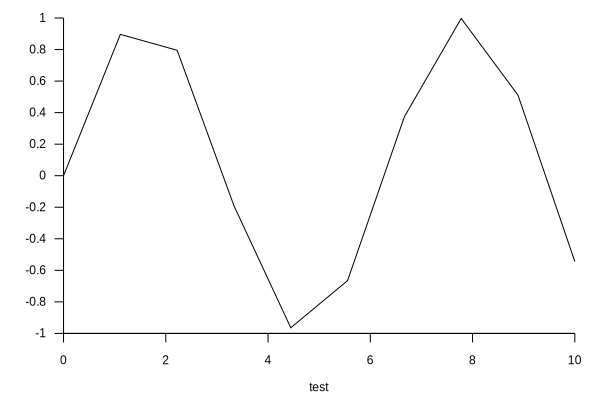

- : unit = ()


In [5]:
let _ =
  let open Gp in
  let figure (module P : Plot) =
    P.plot (L [ x; y ]) (default_props @ [ xlabel "test" ])
  in
  Juplot.draw ~fmt:`svg figure

In [59]:
(*load model parameters
perform inference on unseen data 
show iterations of ilqr 
Overall structure :
- presentation of the model with the plot (5min)
- highlight the key difference with LFADS (2min)
- brief overview of the training (not done here) (2min)
- illustration of the inference on the monkey Maze data 
-> show inference on training data
-> show how we directly get the co-smoothing by cutting the matrix
-> highlight how we can also do inference on a shorter/longer chunk if we throw away the uncertainty 



TO DO : 
[ ] Show co-smoothing etc
[ ] Show inference on longer or shorter chunk (if we want)
[ ] Show parameters of the RNN
[ ] Prepare the "slides'/pictures showing a description of the model
[ ] Consider adding plots of the Duffing?

*)

error: compile_error

In [7]:

type setup =
  { n : int
  ; m : int
  ; n_trials : int
  ; n_steps : int
  ; n_neural : int
  }

let n = 90
let m = 15
let dt = 5E-3
let n_neurons = 137
let n_beg = n/m

let setup = { n; m; n_trials = 1; n_steps = 140; n_neural = n_neurons }



module U = Prior.Student (struct
  let n_beg = (n / m)
  let m = m
end)

module L = Likelihood.Poisson (struct
let label = "neural"
  let dt = AD.F dt
  let link_function = AD.Maths.exp
  let d_link_function = AD.Maths.exp
  let d2_link_function = AD.Maths.exp
  let n_output = n_neurons
  let n = n
end)

module D = Dynamics.Mini_GRU_IO (struct
  let phi x = AD.Maths.(AD.requad x - F 1.)
  let d_phi x = AD.d_requad x
  let sigma x = AD.Maths.sigmoid x
  let d_sigma x = AD.Maths.(exp (neg x) / sqr (F 1. + exp (neg x)))
  let m = m
  let n = n
  let n_beg = Some (n / m)
end)


module X = struct
  let n = setup.n
  let m = setup.m
  let n_steps = setup.n_steps
  let diag_time_cov = false
  let n_beg = n_beg
end


module Make_model
    (U : Prior.T)
    (D : Dynamics.T)
    (L : Likelihood.T) (S : sig
      val n_steps : int
    end) =
struct
  module G = Generative.Make (U) (D) (L)

  module R =
    Recognition.ILQR (U) (D) (L)
      (struct
        let conv_threshold = 1E-6
        let reuse_u = `never
        let diag_time_cov = false
        let n_steps = S.n_steps
      end)

  module Model = Vae.Make (G) (R)
end



type setup = {
  n : int;
  m : int;
  n_trials : int;
  n_steps : int;
  n_neural : int;
}


val n : int = 90


val m : int = 15


val dt : float = 0.005


val n_neurons : int = 137


val n_beg : int = 6


val setup : setup =
  {n = 90; m = 15; n_trials = 1; n_steps = 140; n_neural = 137}


module U :
  sig
    module P :
      sig
        type 'a prm = 'a Ilqr_vae.Prior.Student_P.prm
        val map : f:('a -> 'b) -> 'a prm -> 'b prm
        val fold :
          ?prefix:Base.String.t ->
          init:'a -> f:('a -> 'b * Base.String.t -> 'a) -> 'b prm -> 'a
        type p = Owl_parameters.t prm
        type ph = Owl_parameters.h prm
        val pack : (module Owl_parameters.Packer) -> p -> ph
        val unpack : ph -> Owl_parameters__.AD.t -> p
        val save_to_files :
          ?zip:Base.bool -> ?prefix:Base.String.t -> p -> Base.unit
      end
    val m : Base.int
    val n_beg : Base.int
    val requires_linesearch : Base.bool
    val spatial_stds : prms:P.p -> Ilqr_vae.AD.t
    val sample : prms:P.p -> n_steps:Base.int -> Ilqr_vae.AD.t
    val neg_logp_t :
      prms:P.p ->
      k:Base.int -> x:Ilqr_vae.AD.t -> u:Ilqr_vae.AD.t -> Ilqr_vae.AD.t
    val neg_jac_t :
      (prms:P.p ->
       k:Base.int -> x:Ilqr_vae.AD.t -> u:Ilqr_vae.AD.t -> Ilqr_vae.AD.t)
      B

module L :
  sig
    module P :
      sig
        type 'a prm = 'a Ilqr_vae.Likelihood.Poisson_P.prm
        val map : f:('a -> 'b) -> 'a prm -> 'b prm
        val fold :
          ?prefix:Base.String.t ->
          init:'a -> f:('a -> 'b * Base.String.t -> 'a) -> 'b prm -> 'a
        type p = Owl_parameters.t prm
        type ph = Owl_parameters.h prm
        val pack : (module Owl_parameters.Packer) -> p -> ph
        val unpack : ph -> Owl_parameters__.AD.t -> p
        val save_to_files :
          ?zip:Base.bool -> ?prefix:Base.String.t -> p -> Base.unit
      end
    type output_t = Ilqr_vae.AD.t
    type output = Ilqr_vae.AD.t
    val n : Base.int
    val requires_linesearch : Base.bool
    val label : Base.string
    val save_output :
      ?zip:Base.bool -> ?prefix:Base.string -> output -> Base.unit
    val output_slice : k:Base.int -> output -> output_t
    val numel : output -> Base.int
    val stats : output Base.Array.t -> output * output
    val pre_sample : prms:P.p -> z

module D :
  sig
    module P :
      sig
        type 'a prm = 'a Ilqr_vae.Dynamics.Mini_GRU_IO_P.prm
        val map : f:('a -> 'b) -> 'a prm -> 'b prm
        val fold :
          ?prefix:Base.String.t ->
          init:'a -> f:('a -> 'b * Base.String.t -> 'a) -> 'b prm -> 'a
        type p = Owl_parameters.t prm
        type ph = Owl_parameters.h prm
        val pack : (module Owl_parameters.Packer) -> p -> ph
        val unpack : ph -> Owl_parameters__.AD.t -> p
        val save_to_files :
          ?zip:Base.bool -> ?prefix:Base.String.t -> p -> Base.unit
      end
    val n : Base.int
    val m : Base.int
    val n_beg : Base.int
    val requires_linesearch : Base.bool
    val dyn :
      theta:P.p ->
      k:Base.int -> x:Ilqr_vae.AD.t -> u:Ilqr_vae.AD.t -> Ilqr_vae.AD.t
    val dyn_x :
      (theta:P.p ->
       k:Base.int -> x:Ilqr_vae.AD.t -> u:Ilqr_vae.AD.t -> Ilqr_vae.AD.t)
      Base.option
    val dyn_u :
      (theta:P.p ->
       k:Base.int -> x:Ilqr_vae.AD.t -> u:Ilqr

module X :
  sig
    val n : int
    val m : int
    val n_steps : int
    val diag_time_cov : bool
    val n_beg : int
  end


module Make_model :
  functor (U : Ilqr_vae.Prior.T) (D : Ilqr_vae.Dynamics.T)
    (L : Ilqr_vae.Likelihood.T) (S : sig val n_steps : int end) ->
    sig
      module G :
        sig
          val n : int
          val m : int
          val n_beg : int
          module U :
            sig
              module P :
                sig
                  type 'a prm = 'a U.P.prm
                  val map : f:('a -> 'b) -> 'a prm -> 'b prm
                  val fold :
                    ?prefix:Base.String.t ->
                    init:'a ->
                    f:('a -> 'b * Base.String.t -> 'a) -> 'b prm -> 'a
                  type p = Owl_parameters.t prm
                  type ph = Owl_parameters.h prm
                  val pack : (module Owl_parameters.Packer) -> p -> ph
                  val unpack : ph -> Owl_parameters__.AD.t -> p
                  val save_to_files :
                    ?zip:Base.bool -> ?prefix:Base.String.t -> p -> Base.unit
                end
              val

In [8]:
open Owl_parameters
open Base
open Vae

let train_spikes_in = Arr.load_npy "nlb/train_spikes_in.npy" |> fun z -> Arr.(z -$ 0.5)
let eval_spikes_in = Arr.load_npy "nlb/eval_spikes_in.npy" |> fun z -> Arr.(z -$ 0.5)
let train_spikes_out = Arr.load_npy "nlb/train_spikes_out.npy" |> fun z -> Arr.(z -$ 0.5)
let eval_spikes_out = Arr.load_npy "nlb/eval_spikes_out.npy" |> fun z -> Arr.(z -$ 0.5)
let n_train_neurons = (Arr.shape train_spikes_in).(2)
let n_test_neurons = (Arr.shape train_spikes_out).(2)
let n_neurons = n_train_neurons + n_test_neurons
let train_spikes = Arr.concatenate ~axis:2 [| train_spikes_in; train_spikes_out |]

let trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] train_spikes |> fun z -> Arr.reshape z [| -1; n_neurons |]
  in
  let o = AD.pack_arr x in
  Data.pack o
  

val train_spikes_in :
  (float, Bigarray.float64_elt) Owl_dense_ndarray_generic.t = <abstr>


val eval_spikes_in :
  (float, Bigarray.float64_elt) Owl_dense_ndarray_generic.t = <abstr>


val train_spikes_out :
  (float, Bigarray.float64_elt) Owl_dense_ndarray_generic.t = <abstr>


val eval_spikes_out :
  (float, Bigarray.float64_elt) Owl_dense_ndarray_generic.t = <abstr>


val n_train_neurons : int = 137


val n_test_neurons : int = 45


val n_neurons : Base.Int.t = 182


val train_spikes : Owl.Arr.arr = <abstr>


val trial : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t = <abstr>


### Visualize the data 

In [85]:
let spikes_to_plot = Arr.get_slice [ [ 0 ] ] train_spikes |> fun z -> Arr.reshape z [| -1; n_neurons |]

let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 182 (fun i ->
           let st = "p pt 7 ps 0.2 lc black" in
           let fi = Float.of_int i in
           let arr = (Arr.get_slice [ []; [ i ] ] spikes_to_plot)
           in let arr = Arr.(fi$*arr) in
           item (A arr) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "neuron" ; yrange (0.,182.)])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

val spikes_to_plot : Owl.Arr.arr = <abstr>


In [9]:
include Vae_typ
open Vae_typ.P
module Model = Make_model (U) (D) (L) (X)
open Model



module P = Ilqr_vae.Vae_typ.P


module Model :
  sig
    module G :
      sig
        val n : int
        val m : int
        val n_beg : int
        module U :
          sig
            module P :
              sig
                type 'a prm = 'a U.P.prm
                val map : f:('a -> 'b) -> 'a prm -> 'b prm
                val fold :
                  ?prefix:Base.String.t ->
                  init:'a ->
                  f:('a -> 'b * Base.String.t -> 'a) -> 'b prm -> 'a
                type p = Owl_parameters.t prm
                type ph = Owl_parameters.h prm
                val pack : (module Owl_parameters.Packer) -> p -> ph
                val unpack : ph -> Owl_parameters__.AD.t -> p
                val save_to_files :
                  ?zip:Base.bool -> ?prefix:Base.String.t -> p -> Base.unit
              end
            val m : Base.int
            val n_beg : Base.int
            val requires_linesearch : Base.bool
            val spatial_stds : prms:P.p -> Ilqr_vae.AD.t
            val sample : pr

val prms : 'a = <poly>


val u_mean : Ilqr_vae.AD.t = Ilqr_vae.AD.Arr <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


In [54]:
let get_rates prms trial = let u_mean, _, zs =
  let u_mean, _ = R.posterior_mean ~gen_prms:prms.generative prms.recognition trial in
  let u =
    AD.Maths.reshape u_mean [|1;-1;AD.Mat.col_num u_mean |]
  in
  let zs = G.integrate ~prms:prms.generative ~u in
  (*this is of size n_samples x n-steps x n_output *)
  let remove_n_beg = AD.Maths.get_slice [ []; [ G.n_beg - 1; -1 ] ] in
  remove_n_beg u_mean, remove_n_beg u, remove_n_beg zs
in
let z_mean =
  Arr.mean ~axis:0 (AD.unpack_arr zs)
  |> fun x -> Arr.reshape x [| -1; (Arr.shape x).(2) |]
in
let z_mean = AD.pack_arr z_mean in
let open Vae_typ.P in
let open Prior_typ in
let open Generative_typ.P in
let open Likelihood.Poisson_P in 
let c = Owl_parameters.extract prms.generative.likelihood.c in
let bias = Owl_parameters.extract prms.generative.likelihood.bias in
let gain = Owl_parameters.extract prms.generative.likelihood.gain in
AD.Maths.(F dt * gain * exp ((z_mean *@ transpose c) + bias)) |> AD.unpack_arr 

val get_rates :
  (Model.R.G.P.p, Model.R.P.p) Ilqr_vae.Vae_typ.P.prm_ ->
  ([> `o ], Model.R.G.L.output) Ilqr_vae.Data.t -> Ilqr_vae.AD.A.arr = <fun>


In [47]:
let prms = Misc.load_bin "progress_0.params.bin"

let u_mean, all_us = R.posterior_mean ~gen_prms:prms.generative prms.recognition trial

let u_test = (AD.unpack_arr u_mean) |> fun z -> Arr.reshape z [|-1;15|] |> fun z -> Arr.get_slice [[];[0]] z

val prms : 'a = <poly>


val u_mean : Ilqr_vae.AD.t = Ilqr_vae.AD.Arr <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


val u_test : Owl.Arr.arr = <abstr>


val figure : (module Gp.Plot) -> unit = <fun>


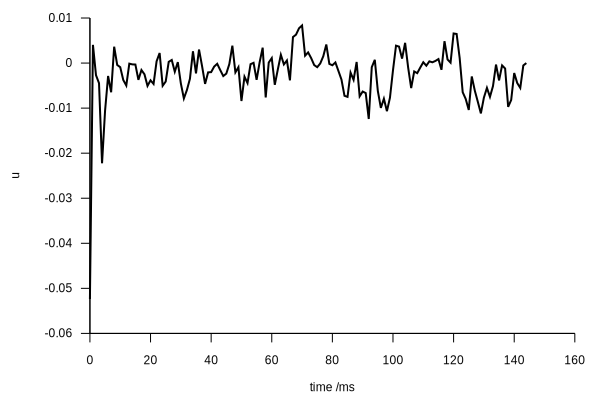

In [48]:
let figure (module P: Plot) =
  P.plot (A u_test) ~style:"l lc 8 lw 2" (default_props @ [ xlabel "time /ms"; ylabel "u" ])
  
let () = Juplot.draw ~fmt:`svg  figure

File "[86]", line 5, characters 6-7:
5 |   let u =
          ^
Warning 26 [unused-var]: unused variable u.


val plot : int -> (module Gp.Plot) -> unit = <fun>


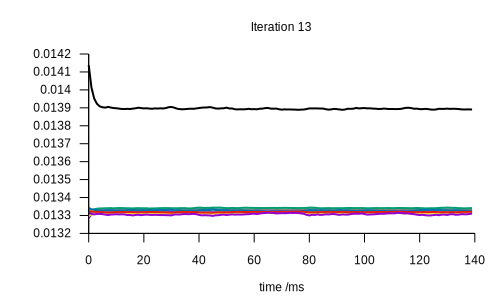

- : unit = ()


In [86]:
(* animation example *)
let plot i (module P : Plot) =
  let it_title = Printf.sprintf "Iteration %i" i in
  let u = List.nth_exn all_us i in 
  let u =
    AD.unpack_arr u
    |> fun z -> Arr.reshape z [| -1; 15 |]
  in
P.plots
      (List.init 10 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ i ] ] u)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "" ; title it_title])

let _ =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iter (List.init (List.length all_us) ~f:(fun i -> i)) (fun phase ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (plot phase);
      Unix.sleepf 0.6)

val rates : Ilqr_vae.AD.A.arr = <abstr>


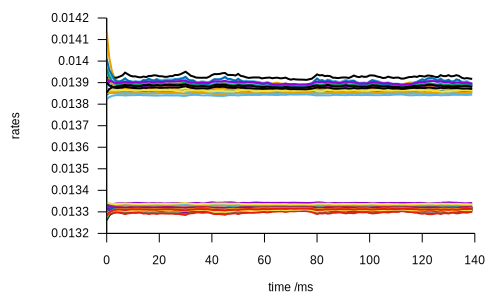

In [55]:
let rates = get_rates prms trial 

let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 2 * i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

### Pre-training 

In [56]:
let prms = Misc.load_bin "progress_3500.params.bin"

let u_mean, all_us = R.posterior_mean ~gen_prms:prms.generative prms.recognition trial

let u_test = (AD.unpack_arr u_mean) |> fun z -> Arr.reshape z [|-1;15|] |> fun z -> Arr.get_slice [[];[0]] z

val prms : 'a = <poly>


val u_mean : Ilqr_vae.AD.t = Ilqr_vae.AD.Arr <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


val u_test : Owl.Arr.arr = <abstr>


val plot : int -> (module Gp.Plot) -> unit = <fun>


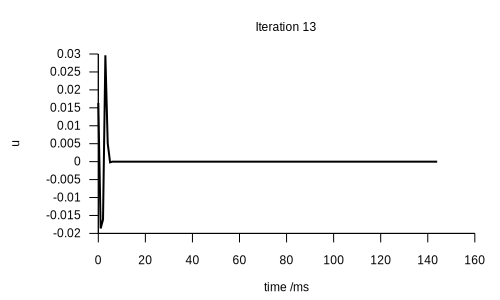

- : unit = ()


In [57]:
let plot i (module P : Plot) =
  let it_title = Printf.sprintf "Iteration %i" i in
  let u = List.nth_exn all_us i in 
  let u =
    AD.unpack_arr u
    |> fun z -> Arr.reshape z [| -1; 15 |] |> fun z -> Arr.get_slice [ []; [ 0 ] ] z
  in
  P.plot
    (A u)
    ~style:"l lc 8 lw 2"
    (default_props @ [ xlabel "time /ms"; ylabel "u"; title it_title ])

let _ =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iter (List.init (List.length all_us) ~f:(fun i -> i)) (fun phase ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (plot phase);
      Unix.sleepf 0.3)

### Trained

In [58]:
let rates = get_rates trial 

let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 2 * i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

error: compile_error